In [1]:
import os
import os.path
from os import path

import numpy as np
np.random.seed(0)
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from pylab import *
from sklearn.metrics import roc_curve,roc_auc_score
from datetime import datetime,timedelta
import wandb
from GenericTools import *
from TripletLossTools import *
from QuadrupletLossTools import *


from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import tensorflow_datasets as tfds

# Allow memory growth for the GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
projectName = "28_omniglot_mining"
project_path = './{0}/'.format(projectName)
model_path = '../azurenb_temp/{0}/'.format(projectName)
if not path.exists(project_path):
    os.mkdir(project_path)
if not path.exists(model_path):
    os.mkdir(model_path)  

## Dataset


In [19]:
def dataSetToArrays(nb_classes,datasets, splitname):
    '''
    Organise the tensorflow dataset into numpy arrays
    Inputs
        nb_classes : global number of classes
        datasets : tensorflow datasets "pack" as they are in the tensorflow_datasets repo
        splitname : which split name from the tfds to take
    Output
        dataset : list of real_nb_class element, each containing numpy array images for each class
        dataset_flat_X : numpy array images of all classes
        dataset_flat_Y : numpy array true labels of all classes
        real_nb_class : number of class detected in this split
    '''
    dataset = []
    tempdataset = []
    dataset_flat_X = []
    dataset_flat_Y = []
    real_nb_class = 0
    
    for n in range(nb_classes):
        tempdataset.append([])
    
    for row in tfds.as_numpy(datasets[splitname]):
       
        
        #Add in the flat dataset
        dataset_flat_X.append(row['image'])
        dataset_flat_Y.append(row['label'])
                
        #Add in the sorted dataset
        tempdataset[row['label']].append(row['image'])
        
    
    #Transform into nparrays, inverted grayscale and normalize
    for n in range(nb_classes):
        if len(tempdataset[n])>1:
            dataset.append(np.mean(np.asarray(tempdataset[n]), axis=-1, keepdims=True)/-255+1)
            real_nb_class += 1
    
    #idem
    dataset_flat_X = np.mean(np.asarray(dataset_flat_X), axis=-1, keepdims=True)/-255+1
    dataset_flat_Y = np.asarray(dataset_flat_Y)
    
    return dataset,dataset_flat_X,dataset_flat_Y,real_nb_class

def buildDataSet():
    omniglot = tfds.builder('omniglot')
    input_shape = omniglot.info.features['image'].shape
    nb_classes = omniglot.info.features['label'].num_classes
    omniglot.download_and_prepare()
    datasets = omniglot.as_dataset()
    
    #Dataset sorted by class
    dataset_train,dataset_train_flat_X,dataset_train_flat_Y,nb_classes_train = dataSetToArrays(nb_classes,datasets,'train')
    dataset_test, dataset_test_flat_X, dataset_test_flat_Y,nb_classes_test  = dataSetToArrays(nb_classes,datasets,'test')
    
    return dataset_train,dataset_test, \
            dataset_train_flat_X,dataset_train_flat_Y,dataset_test_flat_X,dataset_test_flat_Y, \
            nb_classes,nb_classes_train,nb_classes_test


1623 classes, 964 for training, 659 for testing
Checking shapes for class 0 (train) :  (20, 105, 105, 1)
Checking shapes for class 0 (test) :  (20, 105, 105, 1)
Checking shape for flat train dataset X and Y (19280, 105, 105, 1) (19280,)
Checking shape for flat test  dataset X and Y (13180, 105, 105, 1) (13180,)
Checking first samples


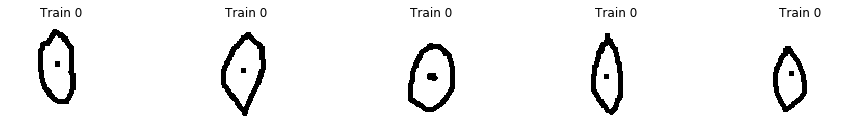

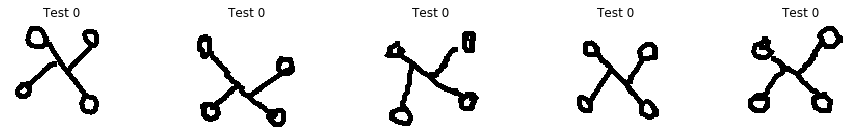

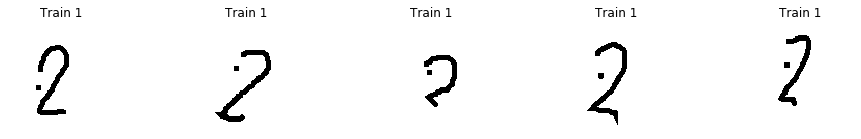

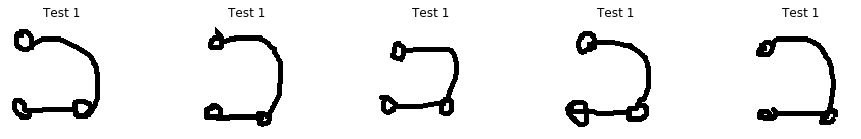

In [20]:
dataset_train,dataset_test, \
    dataset_train_flat_X,dataset_train_flat_Y,dataset_test_flat_X,dataset_test_flat_Y, \
    nb_classes, nb_classes_train,nb_classes_test = buildDataSet()
img_rows, img_cols = dataset_train[0].shape[1],dataset_train[0].shape[2]
input_shape = (img_rows, img_cols, 1)
print("{} classes, {} for training, {} for testing".format(nb_classes, nb_classes_train,nb_classes_test))
print("Checking shapes for class 0 (train) : ",dataset_train[0].shape)
print("Checking shapes for class 0 (test) : ",dataset_test[0].shape)
print("Checking shape for flat train dataset X and Y", dataset_train_flat_X.shape,dataset_train_flat_Y.shape)
print("Checking shape for flat test  dataset X and Y", dataset_test_flat_X.shape,dataset_test_flat_Y.shape)
print("Checking first samples")
for i in range(2):
    DrawPics(dataset_train[i],5,template='Train {}',classnumber=i)
    DrawPics(dataset_test[i],5,template='Test {}',classnumber=i)

### Build Neural Network for computing triplet similarity

In [5]:
def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''

    # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(128, (7,7), activation='relu',padding='same',
                     input_shape=input_shape,
                     kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Conv2D(128, (5,5), activation='relu', kernel_initializer='he_uniform',padding='same',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Conv2D(64, (5,5), activation='relu', kernel_initializer='he_uniform',padding='same',
                     kernel_regularizer=l2(2e-4)))
    network.add(Flatten())
    network.add(Dense(2048, activation='relu',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))
    
    return network

In [6]:
alpha1=1
alpha2=0.5
embeddingsize=20
nb_test_class = 400

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 20)           89268692    anchor_input[0][0]               
                                                                 positive_input[0][0]         

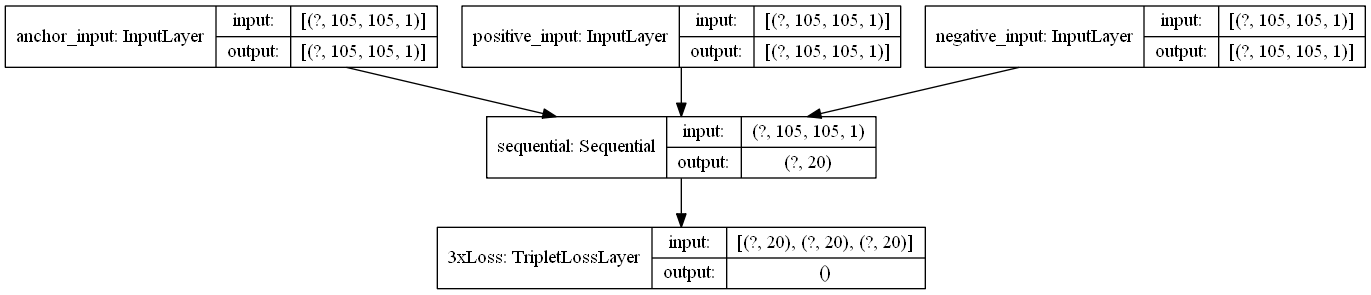

In [7]:
#modele en 3xloss
network3 = build_network(input_shape,embeddingsize=embeddingsize)
network3_train = build_model3(input_shape,network3,margin=alpha1)
optimizer3 = Adam(lr = 0.00006)
network3_train.compile(loss=None,optimizer=optimizer3)
network3_train.summary()
plot_model(network3_train,show_shapes=True, show_layer_names=True, to_file=project_path+'model_summary_3x.png')

In [8]:
def build_metric_network(single_embedding_shape):
    '''
    Define the neural network to learn the metric
    Input : 
            single_embedding_shape : shape of input embeddings or feature map. Must be an array
            
            
    '''
    #compute shape for input
    input_shape = single_embedding_shape
    #the two input embeddings will be concatenated    
    input_shape[0] = input_shape[0]*2
    
     # Neural Network
    network = Sequential(name="learned_metric")
    network.add(Dense(10, activation='relu',
                   input_shape=input_shape, 
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    network.add(Dense(10, activation='relu',                   
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))  
    network.add(Dense(10, activation='relu',                   
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Last layer : binary softmax
    network.add(Dense(2, activation='softmax'))
    
    #Select only one output value from the softmax
    network.add(Lambda(lambda x: x[:,0]))
    
    return network

In [9]:
#modele en 4xloss
network4 = build_network(input_shape,embeddingsize=embeddingsize)
network4.set_weights(network3.get_weights()) #copy weights to have identical networks
metric_network4 = build_metric_network(single_embedding_shape=[embeddingsize])
network4_train = build_model4(input_shape,network4,metric_network4,margin=alpha1, margin2=alpha2)
optimizer4 = Adam(lr = 0.00006)
network4_train.compile(loss=None,optimizer=optimizer4)
network4_train.summary()
plot_model(network4_train,show_shapes=True, show_layer_names=True, to_file=project_path+'model_summary_4x.png')

n_iteration=0

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
negative2_input (InputLayer)    [(None, 105, 105, 1) 0                                            
____________________________________________________________________________________________

In [10]:
#testing our NN with dummy image
featured_img = network4.predict(np.ones((1,img_rows,img_cols,1)))
print(featured_img)

[[ 0.32412332  0.00849277 -0.04194297  0.23046872  0.1669094   0.13860855
  -0.4418669  -0.21768107  0.30963445 -0.08364183  0.19508076  0.34245712
   0.24503495 -0.10798519  0.03545559  0.41586682 -0.01082009 -0.02291073
  -0.18453027  0.10720443]]


### Preparing batch for training


Checking batch width, should be 4 :  4
Shapes in the batch A:(2, 105, 105, 1) P:(2, 105, 105, 1) N:(2, 105, 105, 1) N2:(2, 105, 105, 1)
Shapes in the hardbatch 4x A:(2, 105, 105, 1) P:(2, 105, 105, 1) N:(2, 105, 105, 1)


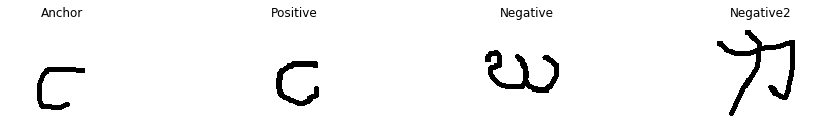

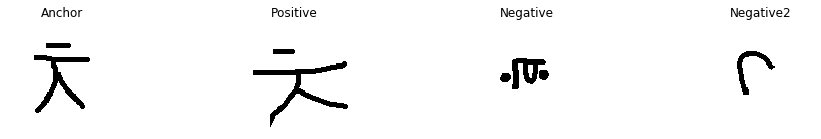

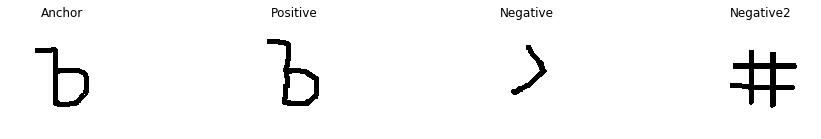

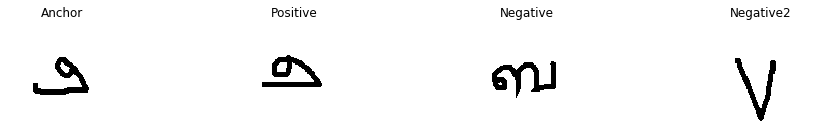

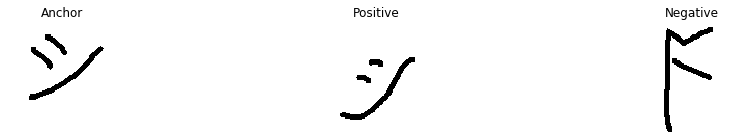

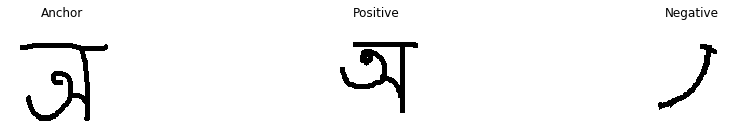

In [11]:
quadruplets = get_batch_random(2,dataset_train)
print("Checking batch width, should be 4 : ",len(quadruplets))
print("Shapes in the batch A:{0} P:{1} N:{2} N2:{3}".format(quadruplets[0].shape, quadruplets[1].shape, quadruplets[2].shape, quadruplets[3].shape))
drawQuadriplets(quadruplets)
hardtriplets,hardquadruplets = get_batch_hard(50,1,1,network3,network4,metric_network4,dataset_train)
print("Shapes in the hardbatch 4x A:{0} P:{1} N:{2}".format(hardquadruplets[0].shape, hardquadruplets[1].shape, hardquadruplets[2].shape, hardquadruplets[3].shape))
drawQuadriplets(hardquadruplets)
drawTriplets(hardtriplets)

### Validation / evaluation



In [10]:
def draw_roc_dual(fpr1, tpr1,thresholds1,auc1,fpr2, tpr2,thresholds2,auc2,n_iteration, name1, name2, namewandb, savewandb=False):
    #find threshold
    targetfpr=1e-3
    _, idx1 = find_nearest(fpr1,targetfpr)
    threshold1 = thresholds1[idx1]
    recall1 = tpr1[idx1]
    _, idx2 = find_nearest(fpr2,targetfpr)
    threshold2 = thresholds2[idx2]
    recall2 = tpr2[idx2]
    
    fig=plt.figure(figsize=(16,6))
    
    subplot = fig.add_subplot(1,2,1)   
    # plot no skill
    subplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    subplot.plot(fpr1, tpr1, marker='.')
    subplot.title.set_text('{5}\nAUC: {0:.3f} @ {4} iterations\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc1,targetfpr,recall1,abs(threshold1),n_iteration,name1 ))
    
    subplot = fig.add_subplot(1,2,2)   
    # plot no skill
    subplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    subplot.plot(fpr2, tpr2, marker='.')
    subplot.title.set_text('{5}\nAUC: {0:.3f} @ {4} iterations\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc2,targetfpr,recall2,abs(threshold2),n_iteration,name2 ))
    
    # show the plot
    fig.show()
    
    if savewandb:
        wandb.log({"Evaluation @ {0} iterations ({1})".format(n_iteration,namewandb):wandb.Image(fig)})
        print("saved")
    
        
def draw_eval(network,n_iteration):
    probs,yprob = compute_probs(network, metricnetwork,dataset_test_flat_X,dataset_test_flat_Y)
    fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
    draw_roc(fpr, tpr,thresholds,auc,n_iteration)
    draw_embeddings(network)
    draw_interdist(network,n_iteration)
    
def draw_eval_dual(network1,network2,metricnetwork2,n_iteration,savewandb=False):
    interdistnbclass = 300
    interdistnbsample = 20
    probs_nbsamples = interdistnbclass*interdistnbsample
    
    t_start=time.time()
    #Computing probs for 3x
    probs1,yprob1 = compute_cache("probs3x", lambda :compute_probs(network1, dataset_test_flat_X[:probs_nbsamples,:,:,:],dataset_test_flat_Y[:probs_nbsamples]), \
                        parameter_dict={'n_iteration':n_iteration,'interdistnbclass':interdistnbclass,'interdistnbsample':interdistnbsample, 'dataset':'test'}, folder=project_path)
    probs1train,yprob1train = compute_cache("probs3x", lambda :compute_probs(network1, dataset_train_flat_X[:probs_nbsamples,:,:,:],dataset_train_flat_Y[:probs_nbsamples]), \
                        parameter_dict={'n_iteration':n_iteration,'interdistnbclass':interdistnbclass,'interdistnbsample':interdistnbsample, 'dataset':'train'}, folder=project_path)
    
    #Computing probs for 4x
    probs2,yprob2 = compute_cache("probs4x", lambda :compute_probs3iVectorized(network2, metricnetwork2,dataset_test_flat_X[:probs_nbsamples,:,:,:],dataset_test_flat_Y[:probs_nbsamples]), \
                        parameter_dict={'n_iteration':n_iteration,'interdistnbclass':interdistnbclass,'interdistnbsample':interdistnbsample, 'dataset':'test'}, folder=project_path)
    probs2train,yprob2train = compute_cache("probs4x", lambda :compute_probs3iVectorized(network2, metricnetwork2,dataset_train_flat_X[:probs_nbsamples,:,:,:],dataset_train_flat_Y[:probs_nbsamples]), \
                        parameter_dict={'n_iteration':n_iteration,'interdistnbclass':interdistnbclass,'interdistnbsample':interdistnbsample, 'dataset':'train'}, folder=project_path)

    #Computing metrics for 3x
    fpr1, tpr1, thresholds1,auc1 = compute_cache("metric3x", lambda :compute_metrics(probs1,yprob1),\
                        parameter_dict={'n_iteration':n_iteration,'interdistnbclass':interdistnbclass,'interdistnbsample':interdistnbsample, 'dataset':'test'}, folder=project_path)
    fpr1train, tpr1train, thresholds1train,auc1train = compute_cache("metric3x", lambda :compute_metrics(probs1train,yprob1train), \
                        parameter_dict={'n_iteration':n_iteration,'interdistnbclass':interdistnbclass,'interdistnbsample':interdistnbsample, 'dataset':'train'}, folder=project_path)                                             
    
    #Computing metrics for 4x
    fpr2, tpr2, thresholds2,auc2 = compute_cache("metric4x", lambda :compute_metrics(probs2,yprob2),\
                        parameter_dict={'n_iteration':n_iteration,'interdistnbclass':interdistnbclass,'interdistnbsample':interdistnbsample, 'dataset':'test'}, folder=project_path)                         
    fpr2train, tpr2train, thresholds2train,auc2train = compute_cache("metric4x", lambda : compute_metrics(probs2train,yprob2train),\
                        parameter_dict={'n_iteration':n_iteration,'interdistnbclass':interdistnbclass,'interdistnbsample':interdistnbsample, 'dataset':'train'}, folder=project_path)                                                                                          
        
    draw_roc_dual(fpr1train, tpr1train,thresholds1train,auc1train,fpr2train, tpr2train,thresholds2train,auc2train,n_iteration, "Triplet (Train)", "Quadruplet (Train)", savewandb)
    draw_roc_dual(fpr1, tpr1,thresholds1,auc1,fpr2, tpr2,thresholds2,auc2,n_iteration, "Triplet (Test)", "Quadruplet (Test)", savewandb)
    #draw_embeddings_dual(network1,network2, savewandb)

    draw_interdist(network1, n_iteration, dataset_train, savewandb, titleprefix="Triplet (Train)",nbclasseval=interdistnbclass, nbsampleperclass=interdistnbsample, folder=project_path)
    draw_interdist_learnedmetric(network2, metricnetwork2,n_iteration, dataset_train, savewandb, titleprefix="Quadruplet (Train)",nbclasseval=interdistnbclass, nbsampleperclass=interdistnbsample, folder=project_path)
    
    draw_interdist(network1, n_iteration, dataset_test, savewandb, titleprefix="Triplet (Test)",nbclasseval=interdistnbclass, nbsampleperclass=interdistnbsample, folder=project_path)
    draw_interdist_learnedmetric(network2, metricnetwork2,n_iteration, dataset_test, savewandb, titleprefix="Quadruplet (Test)",nbclasseval=interdistnbclass, nbsampleperclass=interdistnbsample, folder=project_path)
    elapsed_minute = (time.time()-t_start)/60
    
def compute_CMC_scores():
    #Compute CMC Scores
    cmc3x = compute_cache("cmc3x", lambda :ComputeCMCScoresL2(network3, dataset_test, nb_test_class=nb_test_class ), \
                            parameter_dict={'n_iteration':n_iteration,'nb_test_class':nb_test_class}, folder=project_path)
    cmc4x = compute_cache("cmc4x", lambda :ComputeCMCScoresLearnedMetric(network4, metric_network4, dataset_test, nb_test_class=nb_test_class ), \
                            parameter_dict={'n_iteration':n_iteration,'nb_test_class':nb_test_class}, folder=project_path)
    cmc3xtrain = compute_cache("cmc3xtrain", lambda :ComputeCMCScoresL2(network3, dataset_train, nb_test_class=nb_test_class ), \
                            parameter_dict={'n_iteration':n_iteration,'nb_test_class':nb_test_class}, folder=project_path)
    cmc4xtrain = compute_cache("cmc4xtrain", lambda :ComputeCMCScoresLearnedMetric(network4, metric_network4, dataset_train, nb_test_class=nb_test_class ), \
                            parameter_dict={'n_iteration':n_iteration,'nb_test_class':nb_test_class}, folder=project_path)

    cmc_dict ={
        '3x @ {0} iterations'.format(n_iteration): cmc3x ,
        '4x @ {0} iterations'.format(n_iteration): cmc4x,
        '3x @ {0} iterations (train)'.format(n_iteration): cmc3xtrain,
        '4x @ {0} iterations (train)'.format(n_iteration): cmc4xtrain}

    from CMC import CMC
    cmc = CMC(cmc_dict)

    #custimised color and marker
    new_color = ['r','g','r','g','m','y','orange','brown']
    new_marker = ['*','o','s','v','X','*','.','P']
    cmc = CMC(cmc_dict,color=new_color,marker=new_marker)
    #simple plot
    cmc.plot(title = 'CMC on OMNIGLOT ({0} test IDs)'.format(nb_test_class))

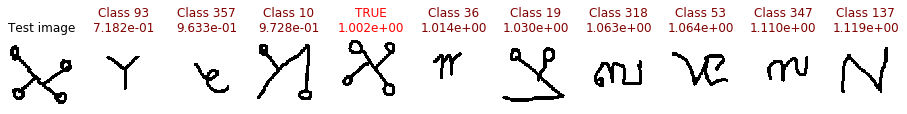

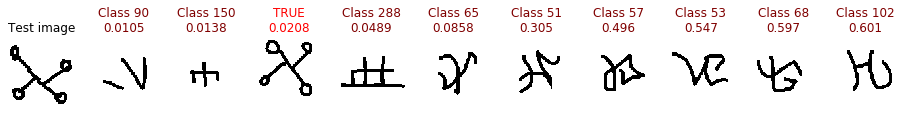

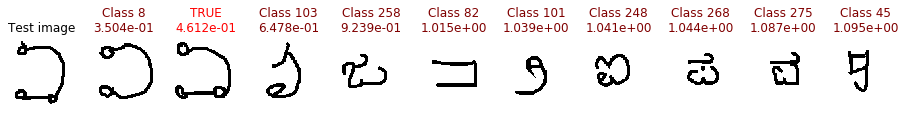

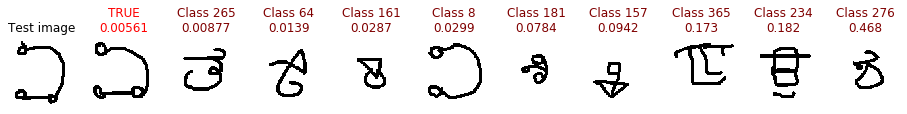

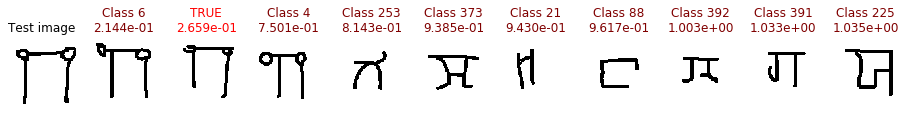

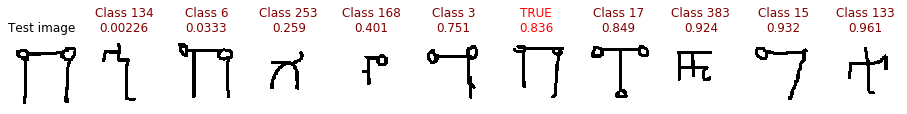

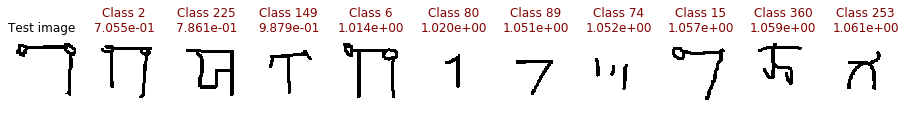

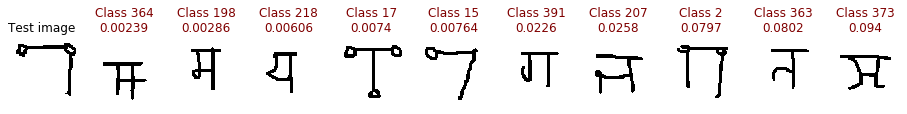

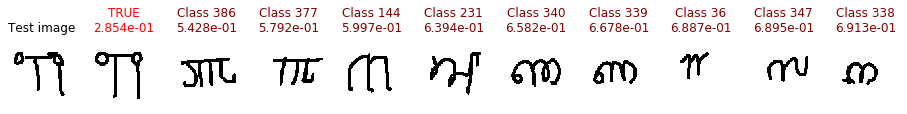

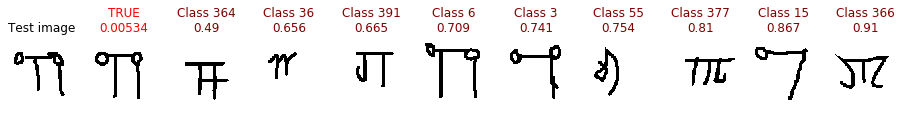

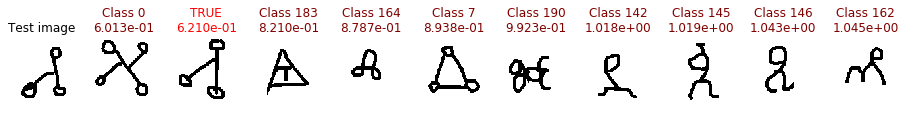

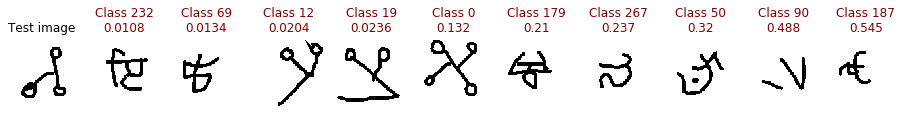

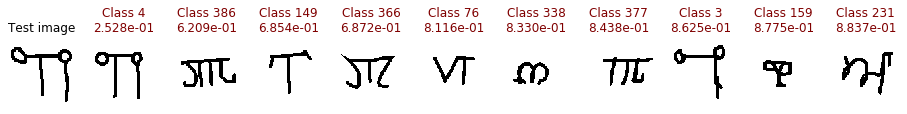

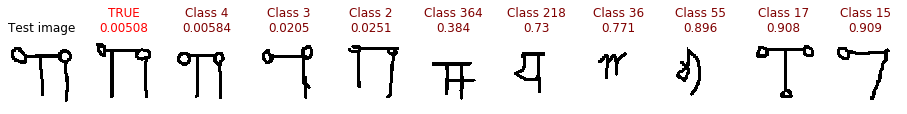

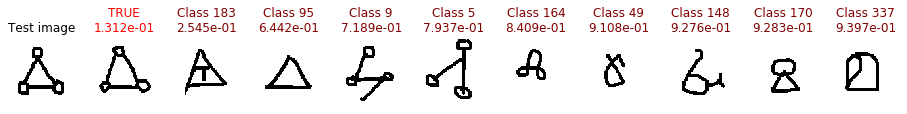

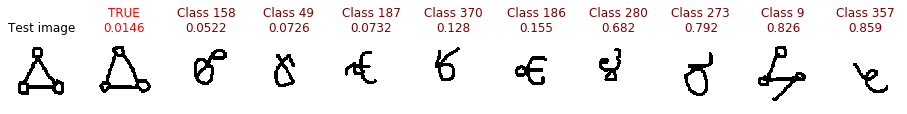

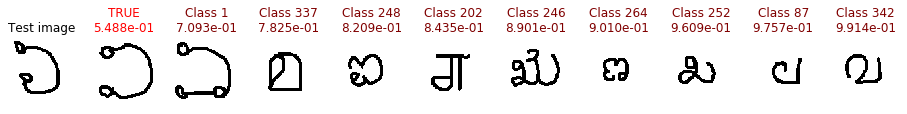

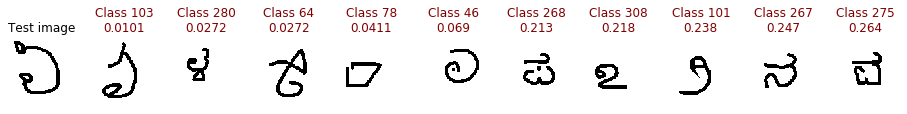

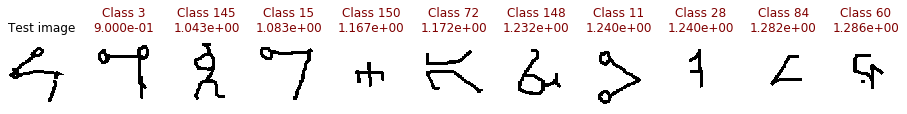

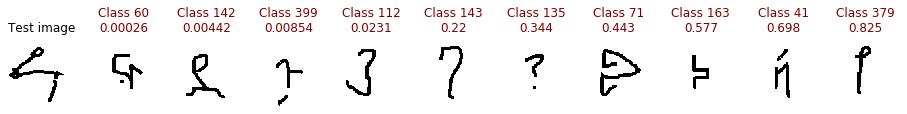

In [142]:
for i in range(10):
    DrawTestImageWithRank(network3,np.expand_dims(dataset_test[i][1,:,:,:],axis=0),dataset_test,threshold=abs(0), classindicator=i,nb_test_class=nb_test_class)
    DrawTestImageLearnedMetricWithRank(network4,metric_network4,np.expand_dims(dataset_test[i][1,:,:,:],axis=0),dataset_test,threshold=abs(0), classindicator=i,nb_test_class=400)

### Training

In [11]:
def reloadFromIteration(n):
    global n_iteration
    n_iteration = n
    network3_train.load_weights('{1}3x-temp_weights_{0:08d}.h5'.format(n_iteration,model_path))
    network4_train.load_weights('{1}4x-temp_weights_{0:08d}.h5'.format(n_iteration,model_path))

In [12]:
reloadFromIteration(150000)
wandb.init(project=projectName,  resume='2plj98yy')

wandb: Wandb version 0.8.35 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/crimy/28_omniglot_mining/runs/2plj98yy

ERROR:wandb.run_manager:Streaming file created twice in same run: C:\TFSCrimy\QuadLoss\wandb\run-20200503_214811-2plj98yy\wandb-history.jsonl
ERROR:wandb.run_manager:Streaming file created twice in same run: C:\TFSCrimy\QuadLoss\wandb\run-20200503_214811-2plj98yy\wandb-events.jsonl


In [13]:
# Hyper parameters
evaluate_every = 5000 # interval for evaluating on one-shot tasks
n_iter = 200000-n_iteration # No. of training iterations
log_every = 50
sample_batch_size = 16

In [15]:
wandb.init(project=projectName)
wandb.config.alpha1 = alpha1
wandb.config.alpha2 = alpha2
wandb.config.sample_batch_size = sample_batch_size
wandb.config.learningrate = K.eval(optimizer4.lr) 
#wandb.init(project=projectName,  resume='1yfvoyb3')

wandb: Wandb version 0.8.35 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Computing probs for 3x
Computing probs for 4x
Computing metrics for 3x
Computing metrics for 4x


C:\Users\Crimy\AppData\Local\Continuum\anaconda3\envs\QuadLoss\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Computing L2 distance done                                                                                        


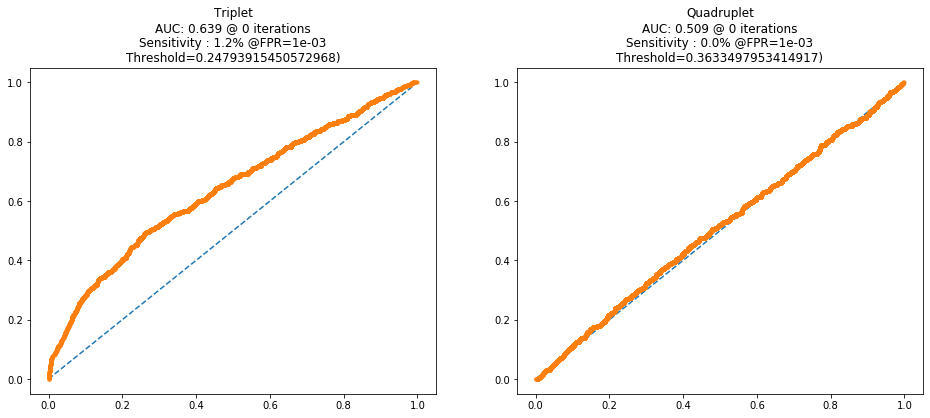

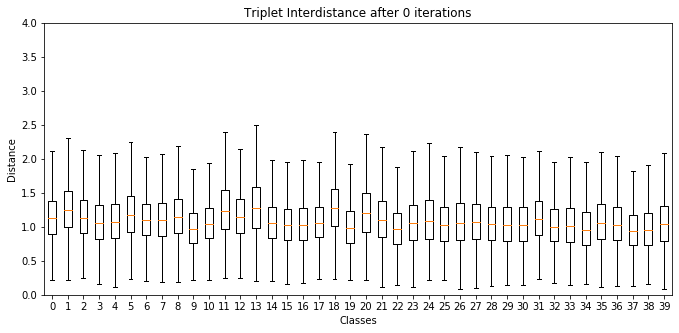

Computing learned distance done                                  


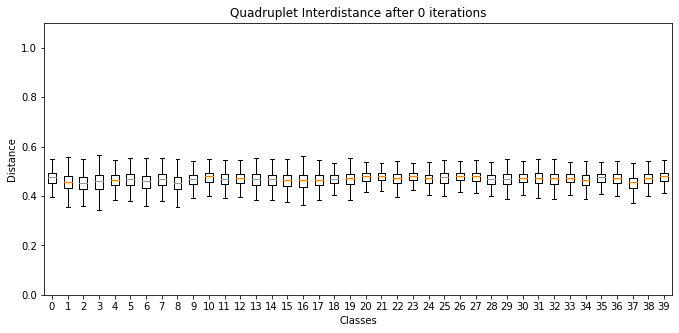

Evaluation time : 1.6501907070477804 min


In [18]:
#Testing on an untrained network
draw_eval_dual(network3,network4,metric_network4,n_iteration,savewandb=True)

Reloading cmc3x for n_iteration=0, nb_test_class=400, 
Reloading cmc4x for n_iteration=0, nb_test_class=400, 
Reloading cmc3xtrain for n_iteration=0, nb_test_class=400, 
Reloading cmc4xtrain for n_iteration=0, nb_test_class=400, 


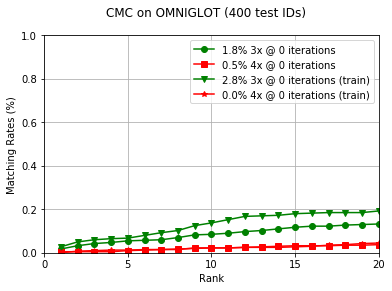

In [15]:
#CMC Scores on untrained systems
compute_CMC_scores()

In [14]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    microtask_start =time.time() 
    triplets,quadruplets = get_batch_hardOptimized(100,16,16,network3,network4,metric_network4, dataset_train)
    timetogetbatch = time.time()-microtask_start
    microtask_start =time.time() 
    loss1 = network3_train.train_on_batch(triplets, None)
    timebatch3 = time.time()-microtask_start
    microtask_start =time.time() 
    loss2 = network4_train.train_on_batch(quadruplets, None)
    timebatch4 = time.time()-microtask_start
    n_iteration += 1
    if i % log_every == 0:
        wandb.log({'loss3x': loss1,'loss4x': loss2}, step=n_iteration)
    if i % evaluate_every == 0:
        elapsed_minutes = (time.time()-t_start)/60.0
        rate = i/elapsed_minutes 
        eta = datetime.now()+timedelta(minutes=(n_iter-i)/rate)
        eta = eta + timedelta(hours=0) #french time
        print("[{4}] iteration {0}: {1:.1f} iter/min, Train Loss: {2} {3}, eta : {5}".format(i, rate,loss1,loss2,n_iteration,eta.strftime("%Y-%m-%d %H:%M:%S") ))
        network3_train.save_weights('{1}3x-temp_weights_{0:08d}.h5'.format(n_iteration,model_path))
        network4_train.save_weights('{1}4x-temp_weights_{0:08d}.h5'.format(n_iteration,model_path))      
#Final save
network3_train.save_weights('{1}3x-temp_weights_{0:08d}.h5'.format(n_iteration,model_path))
network4_train.save_weights('{1}4x-temp_weights_{0:08d}.h5'.format(n_iteration,model_path))     
print("Done !")

Starting training process!
-------------------------------------


wandb: Wandb version 0.8.35 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[155000] iteration 5000: 86.9 iter/min, Train Loss: 0.7753361463546753 1.4342271089553833, eta : 2020-05-04 09:24:01
[160000] iteration 10000: 86.9 iter/min, Train Loss: 0.8254945278167725 1.0150723457336426, eta : 2020-05-04 09:23:59
[165000] iteration 15000: 86.9 iter/min, Train Loss: 0.5831255912780762 0.9705867171287537, eta : 2020-05-04 09:24:05
[170000] iteration 20000: 86.9 iter/min, Train Loss: 1.782701015472412 2.7869131565093994, eta : 2020-05-04 09:24:03
[175000] iteration 25000: 87.2 iter/min, Train Loss: 0.6113688945770264 1.9537960290908813, eta : 2020-05-04 09:22:09
[180000] iteration 30000: 87.4 iter/min, Train Loss: 1.2998476028442383 1.6961958408355713, eta : 2020-05-04 09:20:23
[185000] iteration 35000: 87.6 iter/min, Train Loss: 0.572998583316803 1.2408416271209717, eta : 2020-05-04 09:19:09
[190000] iteration 40000: 87.8 iter/min, Train Loss: 0.547243595123291 1.5070703029632568, eta : 2020-05-04 09:18:15
[195000] iteration 45000: 87.9 iter/min, Train Loss: 0.68847

Computing probs for 3x
Computing probs for 4x
Computing metrics for 3x
Computing metrics for 4x


C:\Users\Crimy\AppData\Local\Continuum\anaconda3\envs\QuadLoss\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Computing L2 distance done                                                                      


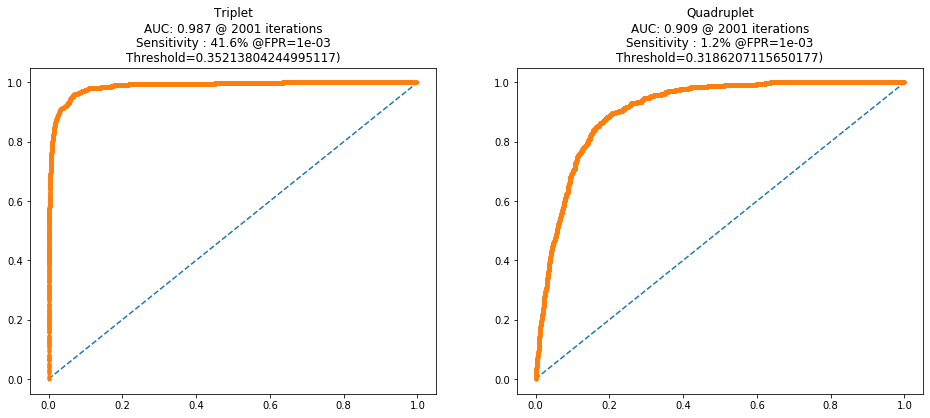

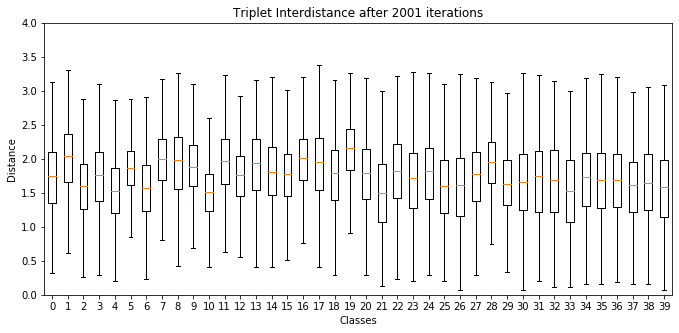

Computing learned distance done                                  


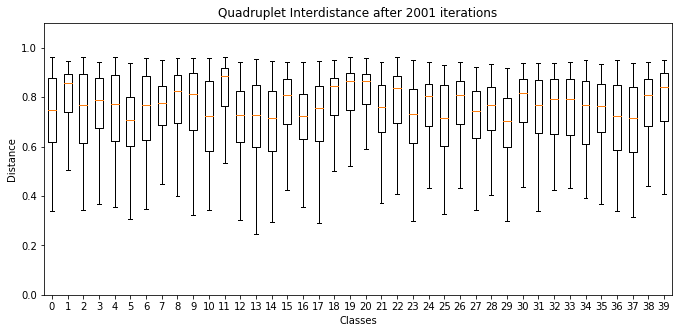

Evaluation time : 1.644360605875651 min


In [33]:
#Full evaluation
draw_eval_dual(network3,network4,metric_network4,n_iteration, savewandb=True)

In [32]:
print(timetogetbatch,timebatch3,timebatch4)

1.3342187404632568 0.12648940086364746 0.14773035049438477


In [ ]:
def DisplayFeatureMaps(network,n, name):
    # retrieve weights from the second hidden layer
    filters, biases = network.layers[0].get_weights()
    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    # plot first few filters
    n_filters, ix = n, 1
    
    for i in range(n_filters):
        # get the filter
        f = filters[:, :, :, i]
        # plot each channel separately
        for j in range(1):
            # specify subplot and turn of axis
            ax = plt.subplot(n_filters, 4, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='gray')
            ix += 1
    # show the figure
    wandb.log({name:plt})
    plt.show()
DisplayFeatureMaps(network3,4, "CNN Filters 3xLoss")
DisplayFeatureMaps(network4,4, "CNN Filters 4xLoss")

Reloading probs3x for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, dataset=test, 
Reloading probs3x for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, dataset=train, 
Reloading probs4x for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, dataset=test, 
Reloading probs4x for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, dataset=train, 
Reloading metric3x for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, dataset=test, 
Reloading metric3x for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, dataset=train, 
Reloading metric4x for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, dataset=test, 
Reloading metric4x for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, dataset=train, 


C:\Users\Crimy\AppData\Local\Continuum\anaconda3\envs\QuadLoss\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Crimy\AppData\Local\Continuum\anaconda3\envs\QuadLoss\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


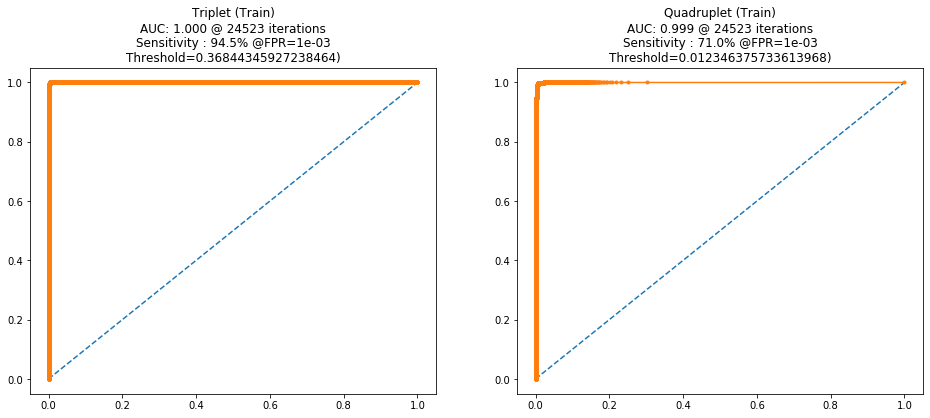

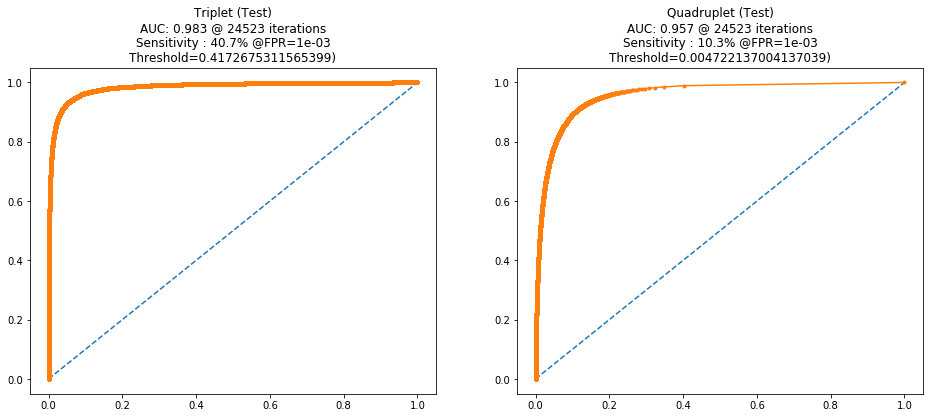

In [27]:
draw_eval_dual(network3,network4,metric_network4,n_iteration, savewandb=False)

Reloading probs3x for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, dataset=test, 
Reloading probs3x for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, dataset=train, 
Reloading probs4x for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, dataset=test, 
Reloading probs4x for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, dataset=train, 
Reloading metric3x for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, dataset=test, 
Reloading metric3x for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, dataset=train, 
Reloading metric4x for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, dataset=test, 
Reloading metric4x for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, dataset=train, 


C:\Users\Crimy\AppData\Local\Continuum\anaconda3\envs\QuadLoss\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Crimy\AppData\Local\Continuum\anaconda3\envs\QuadLoss\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Reloading interdist_Triplet (Train) for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, 


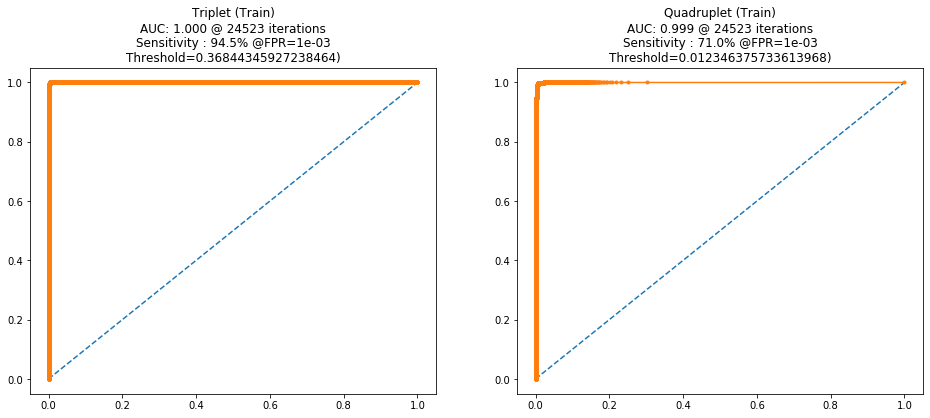

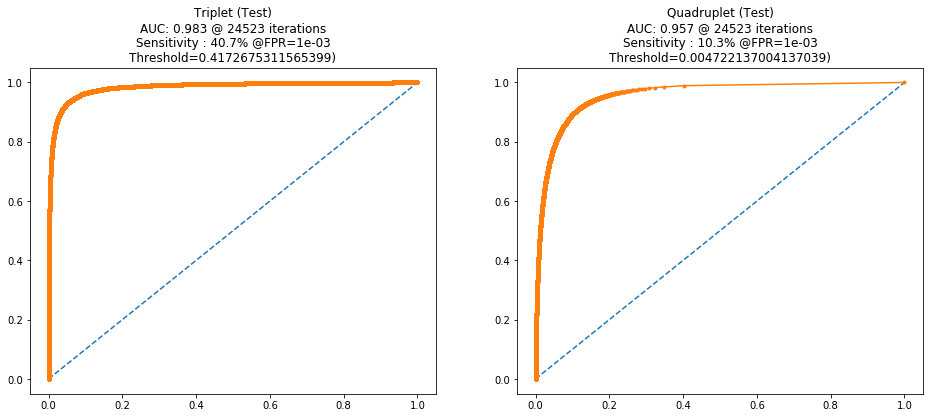

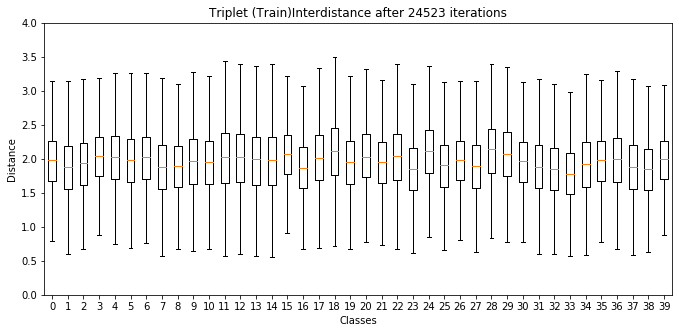

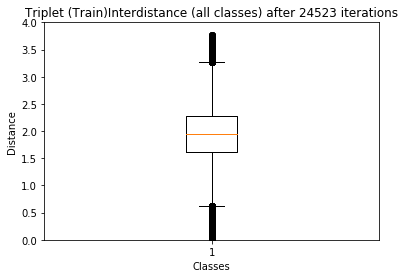

Reloading interdist_Quadruplet (Train) for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, 


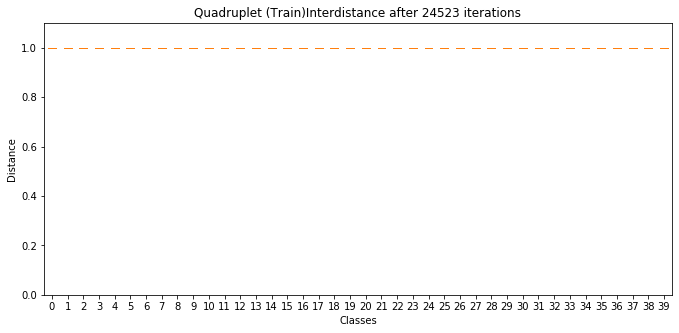

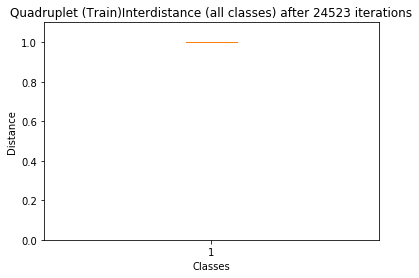

Reloading interdist_Triplet (Test) for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, 


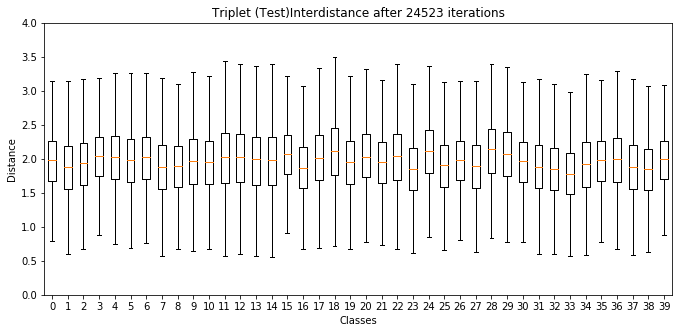

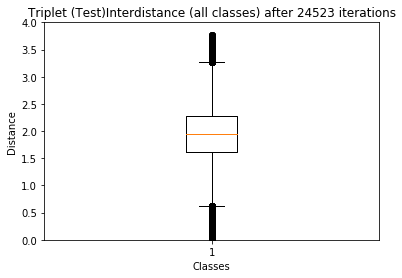

Computing interdist_Quadruplet (Test) for n_iteration=24523, interdistnbclass=300, interdistnbsample=20, 
Computing learned distance done                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

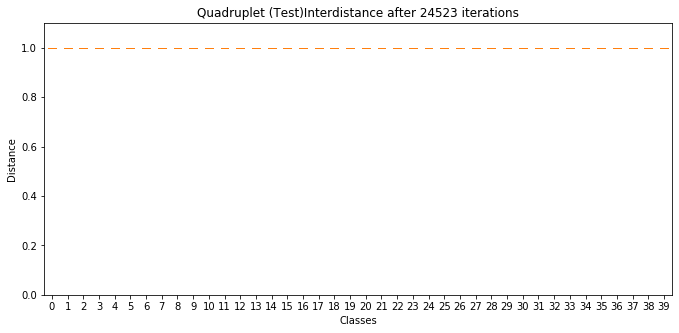

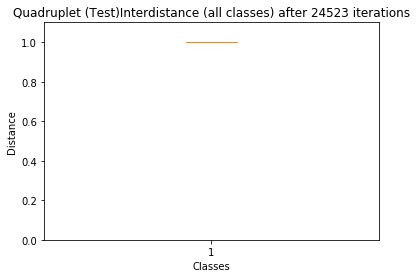

In [14]:
draw_eval_dual(network3,network4,metric_network4,n_iteration, savewandb=False)

Reloading cmc3x for n_iteration=24523, nb_test_class=400, 
Reloading cmc4x for n_iteration=24523, nb_test_class=400, 
Reloading cmc3xtrain for n_iteration=24523, nb_test_class=400, 
Computing cmc4xtrain for n_iteration=24523, nb_test_class=400, 


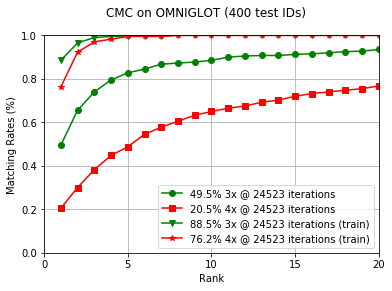

In [16]:
compute_CMC_scores()

hardtriplets equals	 True hardquadruplets equals	 True 1.5434143543243408 0.6997923851013184 -55%
hardtriplets equals	 True hardquadruplets equals	 True 1.5504441261291504 0.5498321056365967 -65%
hardtriplets equals	 True hardquadruplets equals	 True 1.1705844402313232 0.5537629127502441 -53%
hardtriplets equals	 True hardquadruplets equals	 True 1.1576547622680664 0.5737886428833008 -50%
hardtriplets equals	 True hardquadruplets equals	 True 1.1795916557312012 0.554772138595581 -53%
hardtriplets equals	 True hardquadruplets equals	 True 1.1565887928009033 0.5347950458526611 -54%
hardtriplets equals	 True hardquadruplets equals	 True 1.1555793285369873 0.542811393737793 -53%
hardtriplets equals	 True hardquadruplets equals	 True 1.180591344833374 0.5348169803619385 -55%
hardtriplets equals	 True hardquadruplets equals	 True 1.1425485610961914 0.5448582172393799 -52%
hardtriplets equals	 True hardquadruplets equals	 True 1.1645760536193848 0.5357820987701416 -54%


Computing cmc3x for n_iteration=50000, nb_test_class=400, 
Computing cmc4x for n_iteration=50000, nb_test_class=400, 
Computing cmc3xtrain for n_iteration=50000, nb_test_class=400, 
Computing cmc4xtrain for n_iteration=50000, nb_test_class=400, 


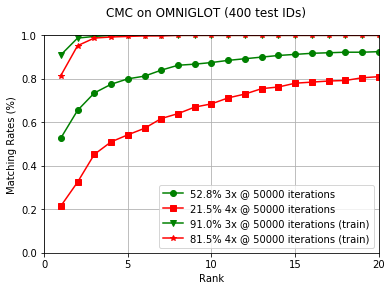

In [15]:
compute_CMC_scores()

Computing cmc3x for n_iteration=100000, nb_test_class=400, 
Computing cmc4x for n_iteration=100000, nb_test_class=400, 
Computing cmc3xtrain for n_iteration=100000, nb_test_class=400, 
Computing cmc4xtrain for n_iteration=100000, nb_test_class=400, 


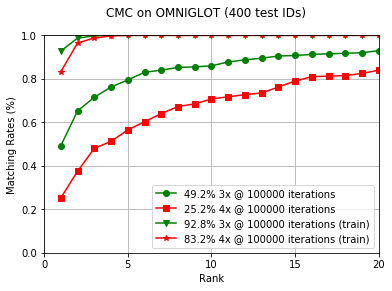

In [17]:
compute_CMC_scores()

Computing cmc3x for n_iteration=150000, nb_test_class=400, 
Computing cmc4x for n_iteration=150000, nb_test_class=400, 
Computing cmc3xtrain for n_iteration=150000, nb_test_class=400, 
Computing cmc4xtrain for n_iteration=150000, nb_test_class=400, 


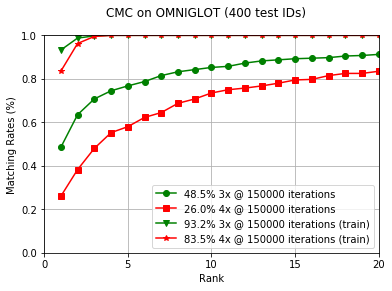

In [16]:
compute_CMC_scores()

Reloading cmc3x for n_iteration=200000, nb_test_class=400, 
Reloading cmc4x for n_iteration=200000, nb_test_class=400, 
Reloading cmc3xtrain for n_iteration=200000, nb_test_class=400, 
Reloading cmc4xtrain for n_iteration=200000, nb_test_class=400, 


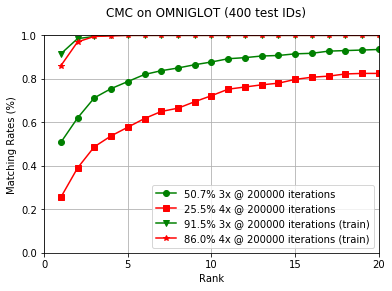

Reloading probs3x for n_iteration=200000, interdistnbclass=300, interdistnbsample=20, dataset=test, 
Reloading probs3x for n_iteration=200000, interdistnbclass=300, interdistnbsample=20, dataset=train, 
Reloading probs4x for n_iteration=200000, interdistnbclass=300, interdistnbsample=20, dataset=test, 
Reloading probs4x for n_iteration=200000, interdistnbclass=300, interdistnbsample=20, dataset=train, 
Reloading metric3x for n_iteration=200000, interdistnbclass=300, interdistnbsample=20, dataset=test, 
Reloading metric3x for n_iteration=200000, interdistnbclass=300, interdistnbsample=20, dataset=train, 
Reloading metric4x for n_iteration=200000, interdistnbclass=300, interdistnbsample=20, dataset=test, 
Reloading metric4x for n_iteration=200000, interdistnbclass=300, interdistnbsample=20, dataset=train, 


C:\Users\Crimy\AppData\Local\Continuum\anaconda3\envs\QuadLoss\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Crimy\AppData\Local\Continuum\anaconda3\envs\QuadLoss\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Reloading interdist_Triplet (Train) for n_iteration=200000, interdistnbclass=300, interdistnbsample=20, 


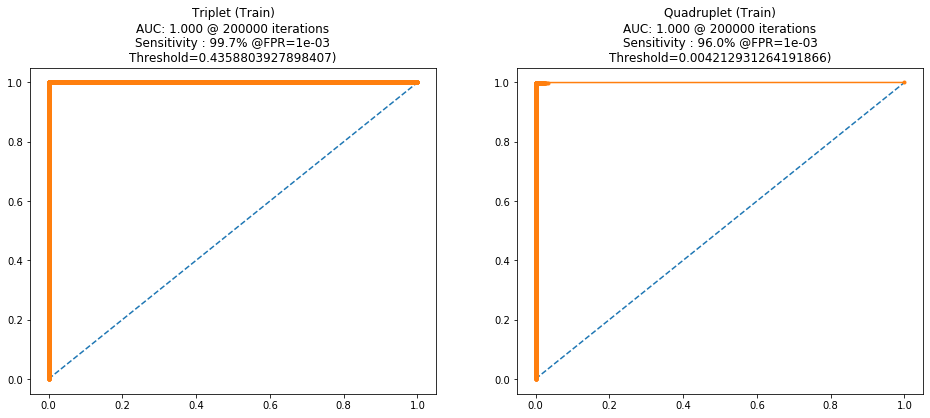

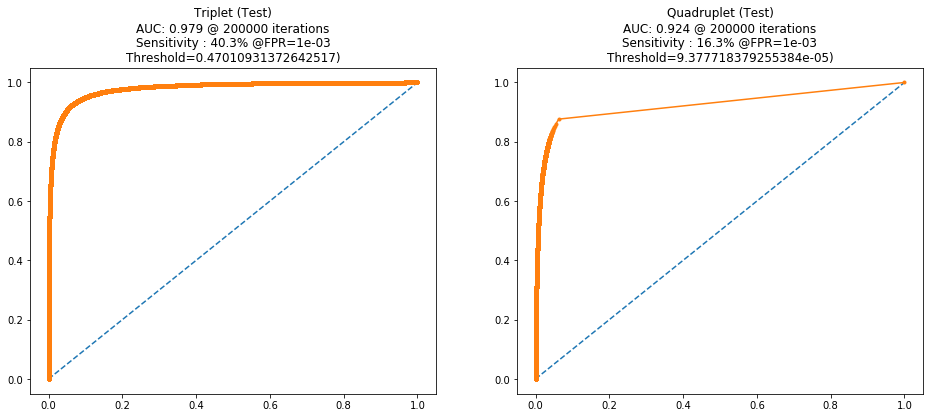

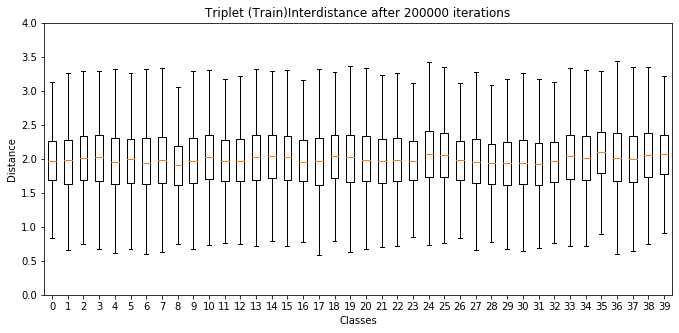

wandb: Wandb version 0.8.35 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


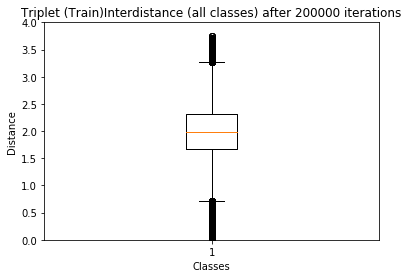

Reloading interdist_Quadruplet (Train) for n_iteration=200000, interdistnbclass=300, interdistnbsample=20, 


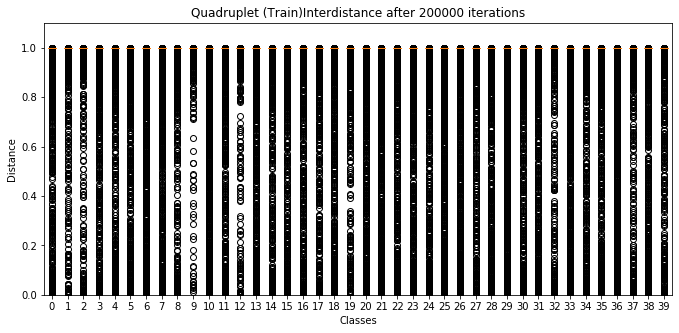

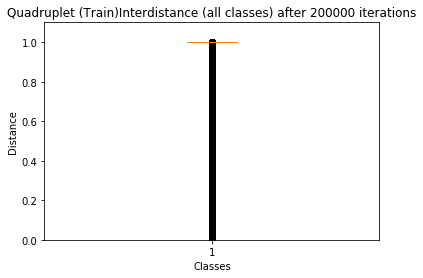

Reloading interdist_Triplet (Test) for n_iteration=200000, interdistnbclass=300, interdistnbsample=20, 


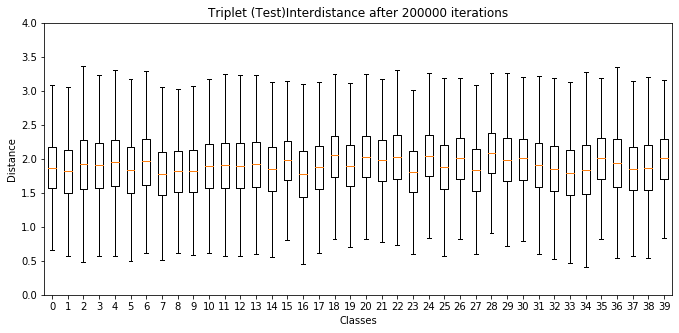

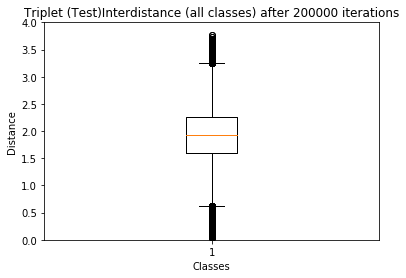

Reloading interdist_Quadruplet (Test) for n_iteration=200000, interdistnbclass=300, interdistnbsample=20, 


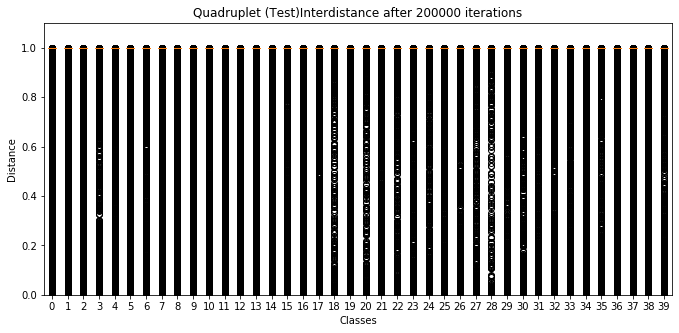

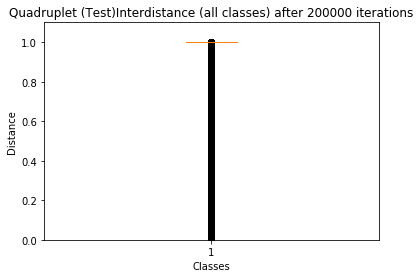

In [16]:
#Full evaluation
compute_CMC_scores()
draw_eval_dual(network3,network4,metric_network4,n_iteration, savewandb=True)